In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import time
from scipy.stats import gaussian_kde
import scipy.stats as stats

In [2]:
from dataset import N2O_synthetic_dataset
from time_series_models_hiddentransfer import LSTMSeq2Seq, GRUSeq2Seq, GRUSeq2SeqWithAttention, TimeSeriesModel, N2OGRU_multitask, RecoGRU_multitask
# from sequence_dataset import SequenceDataset, train_test_split

In [3]:
import kgml_lib

In [4]:
# define functions from kgml_lib
Z_norm = kgml_lib.Z_norm 
Z_norm_reverse = kgml_lib.Z_norm_reverse
get_gpu_memory = kgml_lib.get_gpu_memory
# my_loss = kgml_lib.my_loss
# compute_r2=kgml_lib.R2Loss()

# myloss_mb_flux_mask = kgml_lib.myloss_mb_flux_mask
# check_Rh2SOC_response = kgml_lib.check_Rh2SOC_response

def stop_program():
    raise SystemExit("Program terminated due to using CPU.")


In [5]:
import torch
from torch.utils.data import DataLoader

In [6]:
root_dir = '/users/1/yang6956/PyKGML/datasets/N2O/'
data_path = root_dir +  'input16_output5_pretrain_18yr_unscaled.sav'
output_path = root_dir + 'test_results/'
if not os.path.exists(output_path):
    os.mkdir(output_path)

# pretrained_model = "recotest_v11_exp4.sav_step1"
# output_model = "recotest_v11_exp4_sample.sav_step2"
# synthetic_data = "sys_data2.sav"

dataset = N2O_synthetic_dataset(data_path=data_path, scaler_path=None, out_path=output_path)
dataset.load_data()
dataset.prepare_data()

/users/1/yang6956/PyKGML/code/Five_steps_training/dataset.py:502: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.tensor(torch.load(self.data_path)) # test w

Scalers of the dataset are not provided, will implement normalization in the step of prepare_data()
data size is  torch.Size([1980, 6570, 21])
Inputs include  ['FERTZR_N', 'RADN', 'TMAX_AIR', 'TMIN_AIR', 'HMAX_AIR', 'HMIN_AIR', 'WIND', 'PRECN', 'PDOY', 'PLANTT', 'TBKDS', 'TCSAND', 'TCSILT', 'TPH', 'TCEC', 'TSOC']
Outputs include  ['N2O_FLUX', 'CO2_FLUX', 'WTR_3', 'NH4_3', 'NO3_3']


In [10]:
num_input_features = 16
num_output_features = 5

input_dim = num_input_features
hidden_dim = 64
num_layers = 2
output_dim1 = 4 # first GRU cell predicts 'CO2_FLUX', 'WTR_3', 'NH4_3', 'NO3_3'
output_dim2 = 1 # second GRU cell predicts 'N2O_FLUX' 
output_dim = output_dim1 + output_dim2
dropout=0.2

In [8]:
X = dataset.X  #[365*18, 100, 19]
Y = dataset.Y #[365*18, 100, 3]
N2O = Y[:,:,-5:-4]
print(N2O.size())
Y_scaler = dataset.Yscaler
# X = torch.transpose(X,1, 0) #[100, 365*18, 19]
# Y = torch.transpose(Y,1, 0) #[100, 365*18, 3]

total_sites = X.shape[0]
total_years = int(X.shape[1]/365)
print(total_sites, total_years)
# days_per_year = 365
# total_days = total_years * days_per_year
# num_sites = X.shape[0] #100

batch_size=64
# train_loader, test_loader = model.train_test_split(X, Y1, batch_size)

torch.Size([1980, 6570, 1])
1980 18


In [8]:
# Choose one of the models below:
#model = LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)
# model = GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)

# model = EnhancedGRUModel(input_dim, hidden_dim, num_layers, output_dim)

# model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

# model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim)
model = N2OGRU_multitask(input_dim, hidden_dim, num_layers, output_dim1, output_dim2, dropout)
model.train_test_split(X, Y, total_sites, total_years, batch_size, split_method = 'temporal', year_splitting=False)

In [10]:
learning_rate = 0.001
step_size = 20
max_epoch = 60

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/60 | LR: 0.001000, Train Loss: 0.7546, Test Loss: 0.7483
Epoch 2/60 | LR: 0.001000, Train Loss: 0.5760, Test Loss: 0.6230
Epoch 3/60 | LR: 0.001000, Train Loss: 0.4695, Test Loss: 0.5484
Epoch 4/60 | LR: 0.001000, Train Loss: 0.4085, Test Loss: 0.5097
Epoch 5/60 | LR: 0.001000, Train Loss: 0.3743, Test Loss: 0.4477
Epoch 6/60 | LR: 0.001000, Train Loss: 0.3401, Test Loss: 0.4412
Epoch 7/60 | LR: 0.001000, Train Loss: 0.3127, Test Loss: 0.3952
Epoch 8/60 | LR: 0.001000, Train Loss: 0.2929, Test Loss: 0.4050
Epoch 9/60 | LR: 0.001000, Train Loss: 0.2712, Test Loss: 0.3422
Epoch 10/60 | LR: 0.001000, Train Loss: 0.2486, Test Loss: 0.3045
Epoch 11/60 | LR: 0.001000, Train Loss: 0.2327, Test Loss: 0.2955
Epoch 12/60 | LR: 0.001000, Train Loss: 0.2268, Test Loss: 0.3054
Epoch 13/60 | LR: 0.001000, Train Loss: 0.2244, Test Loss: 0.3000
Epoch 14/60 | LR: 0.001000, Train Loss: 0.2119, Test Loss: 0.2727
Epoch 15/60 | LR: 0.001000, Train Loss: 0.2074, Test Loss: 0.2874
Epoch 16/60 | LR: 0

In [16]:
# model.test(test_loader)
model.test()

Test Loss: 0.0452


In [ ]:
model.plot_training_curves()

In [14]:
modelGRU = GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim2)
modelGRU.train_test_split(X, N2O, total_sites, total_years, batch_size, split_method = 'temporal', year_splitting=False)

learning_rate = 0.001
step_size = 20
max_epoch = 150

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
modelGRU.train_model(LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/150 | LR: 0.001000, Train Loss: 0.9211, Test Loss: 1.0120
Train R2:  0.06 Test R2:  0.08
Epoch 2/150 | LR: 0.001000, Train Loss: 0.8580, Test Loss: 0.9599
Train R2:  0.13 Test R2:  0.13
Epoch 3/150 | LR: 0.001000, Train Loss: 0.7450, Test Loss: 0.7616
Train R2:  0.24 Test R2:  0.26
Epoch 4/150 | LR: 0.001000, Train Loss: 0.5854, Test Loss: 0.6949
Train R2:  0.41 Test R2:  0.28
Epoch 5/150 | LR: 0.001000, Train Loss: 0.4537, Test Loss: 0.5321
Train R2:  0.54 Test R2:  0.39
Epoch 6/150 | LR: 0.001000, Train Loss: 0.4230, Test Loss: 0.4664
Train R2:  0.57 Test R2:  0.45
Epoch 7/150 | LR: 0.001000, Train Loss: 0.3447, Test Loss: 0.4844
Train R2:  0.65 Test R2:  0.49
Epoch 8/150 | LR: 0.001000, Train Loss: 0.3485, Test Loss: 0.4108
Train R2:  0.65 Test R2:  0.50
Epoch 9/150 | LR: 0.001000, Train Loss: 0.3004, Test Loss: 0.3859
Train R2:  0.69 Test R2:  0.50
Epoch 10/150 | LR: 0.001000, Train Loss: 0.2761, Test Loss: 0.3743
Train R2:  0.72 Test R2:  0.52
Epoch 11/150 | LR: 0.001000, 

Epoch 85/150 | LR: 0.000410, Train Loss: 0.1393, Test Loss: 0.2584
Train R2:  0.86 Test R2:  0.58
Epoch 86/150 | LR: 0.000410, Train Loss: 0.1374, Test Loss: 0.2516
Train R2:  0.86 Test R2:  0.59
Epoch 87/150 | LR: 0.000410, Train Loss: 0.1372, Test Loss: 0.2561
Train R2:  0.86 Test R2:  0.58
Epoch 88/150 | LR: 0.000410, Train Loss: 0.1369, Test Loss: 0.2564
Train R2:  0.86 Test R2:  0.58
Epoch 89/150 | LR: 0.000410, Train Loss: 0.1360, Test Loss: 0.2499
Train R2:  0.86 Test R2:  0.59
Epoch 90/150 | LR: 0.000410, Train Loss: 0.1360, Test Loss: 0.2607
Train R2:  0.86 Test R2:  0.58
Epoch 91/150 | LR: 0.000410, Train Loss: 0.1346, Test Loss: 0.2521
Train R2:  0.86 Test R2:  0.59
Epoch 92/150 | LR: 0.000410, Train Loss: 0.1348, Test Loss: 0.2605
Train R2:  0.86 Test R2:  0.58
Epoch 93/150 | LR: 0.000410, Train Loss: 0.1340, Test Loss: 0.2517
Train R2:  0.86 Test R2:  0.59
Epoch 94/150 | LR: 0.000410, Train Loss: 0.1339, Test Loss: 0.2561
Train R2:  0.86 Test R2:  0.58
Epoch 95/150 | LR: 0

/users/1/yang6956/PyKGML/code/Five_steps_training/time_series_models_hiddentransfer.py:341: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(che

In [15]:
modelGRU.test()

Test Loss: 0.3455
Test R2:  0.59


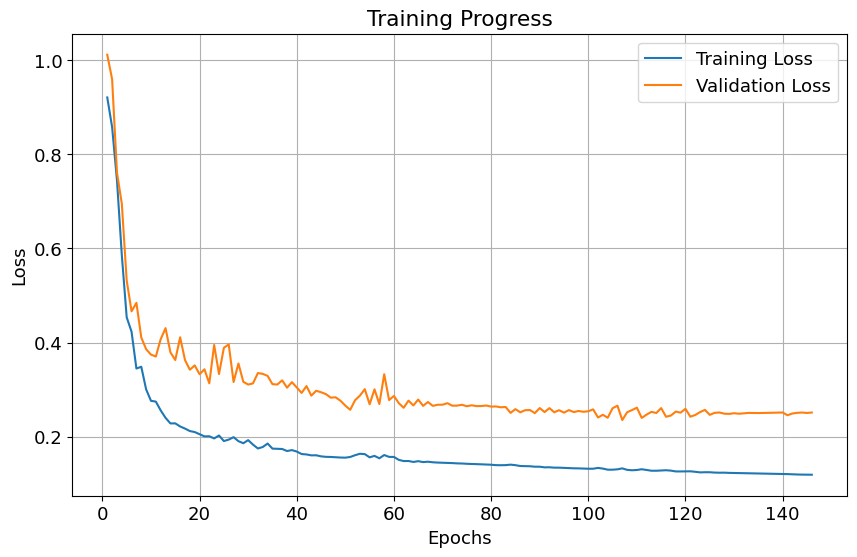

In [16]:
modelGRU.plot_training_curves()

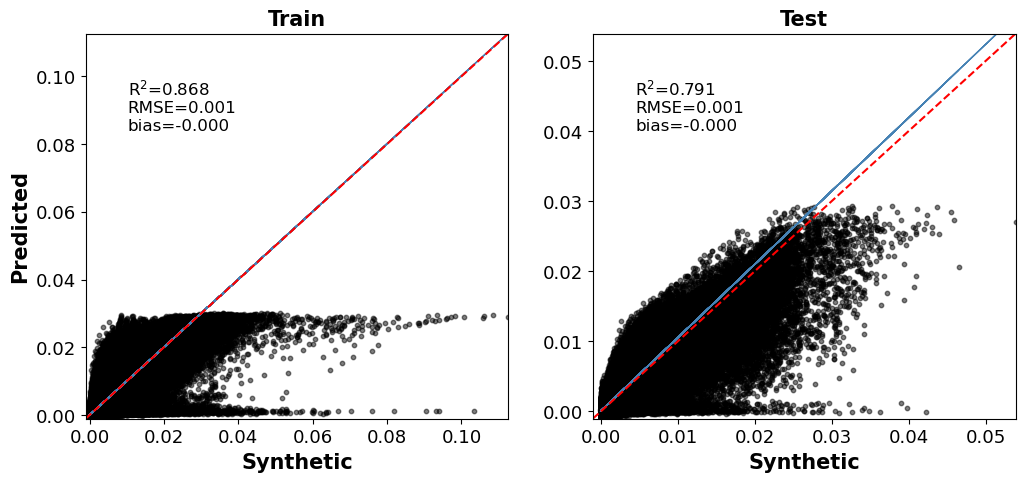

In [17]:
modelGRU.vis_scatter(Y_scaler)